### Score Based SDE (continous-time) denoising

Consider a 1D noisy signal  
$$
y \in \mathbb{R}^n,\quad \mu = 0,\quad \mathrm{Cov}(y)=\Sigma.
$$  
We infer noise parameters  
$$
\mu = 0,\quad \Sigma
$$  
using Gibbs Sampling (+ HMC).

**Natural Images**  
$$
\Sigma_\sigma = \Sigma(\sigma,\psi)
$$  
where, sigma^2 = noise amplitude and psi = spectral indeex

**CMB**  
Model temperature fluctuations as  
$$
\mu = 0,\quad \mathrm{Cov}(y) = \Sigma_\phi,
$$  

where  
$$
\Sigma_\phi = \Sigma(H_0,\;\Omega_b,\;\sigma).
$$  

In both cases, we consider a covariance matrix that is diagonal in Fourier space. We write  
$$
\Sigma_\phi = \sigma^2 \cdot \mathbf{F}^\top \mathbf{D}_\psi \mathbf{F},
$$  
where F is the orthonormal discrete DFT matrix, sigma > 0 controls the noise amplitude, and D_psi is a diagonal matrix parameterized by the power spectrum function S_psi(k):  
$$
\mathbf{D}_\psi = \mathrm{diag}(S_\psi(k)).
$$  
$$
\text{Let } \varepsilon \text{ denote the predicted noise and } \hat{\varepsilon}_k = (\mathbf{F} \varepsilon)_k \text{ be its Fourier coefficients.}
$$
The log-posterior  (for HMC sampling) is given by
$$
\log p(\phi \mid \varepsilon = y - x) = \log p(\varepsilon \mid \phi) + \log p(\phi) + C
$$
Then the analytically tractable negative log-likelihood is given by:  
$$
- \log p(\varepsilon \mid \phi) = \frac{1}{2} \sum_k \left[ \log\left(\sigma^2 S_\psi(k)\right) + \frac{|\hat{\varepsilon}_k|^2}{\sigma^2 S_\psi(k)} \right] + C,
$$  
where \( C \) is an arbitrary constant.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import random
import torch
from torch.utils.data import DataLoader, TensorDataset
import math
import warnings
import importlib
warnings.filterwarnings('ignore')

In [9]:
import importlib
import modules
import modules.comp.nn_based
importlib.reload(modules.comp.nn_based)
from modules.comp.nn_based import *
from sklearn.model_selection import train_test_split

#### Data-Creation 1D (Synthetic)

In [11]:
import modules.utils.noise_create
importlib.reload(modules.utils.noise_create)
from modules.utils.noise_create import create_1d_data, create_1d_data_colored

In [12]:
def plot_results(noisy, clean, denoised, title=""):
    """
    Plot a few examples comparing the noisy input, clean signal, and denoised output.
    """
    num_examples = 3
    plt.figure(figsize=(8, 4))
    for i in range(num_examples):
        plt.subplot(num_examples, 1, i+1)
        plt.plot(clean[i].squeeze().cpu().numpy(), label="Clean Signal", linewidth=2)
        plt.plot(noisy[i].squeeze().cpu().numpy(), label="Noisy Signal", alpha=0.5)
        plt.plot(denoised[i].squeeze().cpu().detach().numpy(), label="Denoised Output", linestyle="--")
        plt.legend(loc="upper right")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

1D Flat PSD (white Noise) - Sine Signal

(10000, 100) (10000, 100) (10000, 100)


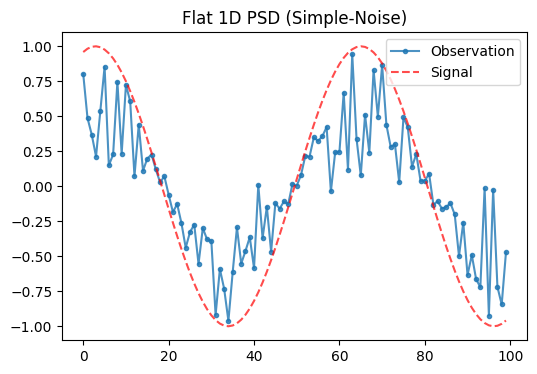

(10000, 100) (10000, 100) (10000, 100)


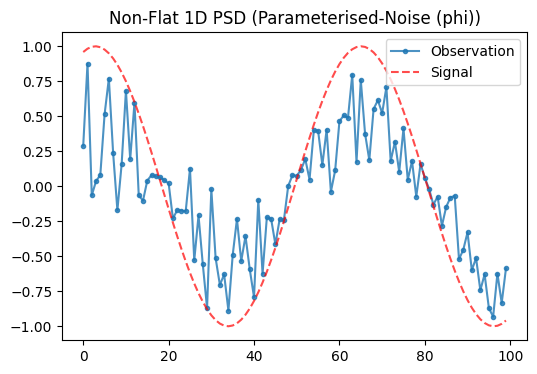

In [18]:
n_samples = 10000 ## num of samples
n_depth = 100 ## sequence-length
rn = random.randint(0, n_samples)

observation, signal, noise = create_1d_data(n_samples=n_samples, n_depth=n_depth)
print(observation.shape, signal.shape, noise.shape)

plt.figure(figsize=(6, 4))

plt.plot(observation[rn], label="Observation", alpha=0.8, marker='.')
plt.plot(signal[rn], label="Signal", linestyle="dashed", alpha=0.7, color = 'red')
plt.title('Flat 1D PSD (Simple-Noise)')
plt.legend()
plt.show()

observation, signal, noise = create_1d_data_colored(n_samples=n_samples, n_depth=n_depth, phi=-1.0, decay=0.1)
print(observation.shape, signal.shape, noise.shape)

plt.figure(figsize=(6, 4))

plt.plot(observation[rn], label="Observation", alpha=0.8, marker='.')
plt.plot(signal[rn], label="Signal", linestyle="dashed", alpha=0.7, color = 'red')
plt.title('Non-Flat 1D PSD (Parameterised-Noise (phi))')
plt.legend()
plt.show()

In [ ]:
observation_train, observation_val, signal_train, signal_val = train_test_split(observation, signal, test_size = 1 - train_split, random_state=28)

print('Shape: ', observation_train.shape, signal_train.shape, observation_val.shape, signal_val.shape)

observation_train = torch.tensor(observation_train, dtype=torch.float32)
signal_train = torch.tensor(signal_train, dtype=torch.float32)
observation_val = torch.tensor(observation_val, dtype=torch.float32)
signal_val = torch.tensor(signal_val, dtype=torch.float32)

dataset_train = TensorDataset(observation_train, signal_train)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = TensorDataset(observation_val, signal_val)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

print(train_loader, val_loader)

1D Non-Flat PSD - Colored Noise - Sine Signal